In [1]:
import npnet as tn
import ocr_data

import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [(5,5)] #[(3,3),(3,3),(3,3),(3,3),(3,3)]
conv_stride = [(3,3)] #[(1,1),(2,2),(1,1),(2,2),(1,1)]
conv_outs = [(4,)] #[(4,),(8,),(8,),(16,),(16,)]
conv_layers = len(conv_kernels)
hidden_shapes = []
hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [4]:
in_layer = tn.Input(input_shape)()
last_layer = in_layer
print(in_layer)
for kernel_shape,out_shape,kernel_stride in zip(conv_kernels,conv_outs,conv_stride):
    last_layer = tn.Conv(kernel_shape,out_shape=out_shape,kernel_stride=kernel_stride,pad=True,neuron=tn.ReLUNeuron)(last_layer)
    print(last_layer)
for hidden_shape in hidden_shapes:
    last_layer = tn.Dense(hidden_shape,neuron=tn.TanhNeuron)(last_layer)
    print(last_layer)
out_layer = tn.Dense(output_shape,neuron=tn.SigmoidNeuron)(last_layer)
print(out_layer)

s = tn.System(inputs=[in_layer],outputs=[out_layer])

Input :: () -> (32, 32)
Conv :: (32, 32) -> (10, 10, 4)
Dense :: (10, 10, 4) -> (26,)
Conv :: (32, 32) -> (10, 10, 4) => Dense :: (10, 10, 4) -> (26,)
Input :: () -> (32, 32) => Conv :: (32, 32) -> (10, 10, 4)


In [5]:
import multiprocessing
import functools

def batch(length=1000):    
    total,failures = 0,0
    state = None
    for true_out,input in ocr_data.tagged_2d_data(length):
        guess_out,state = s.guess([input],return_state=True)
        #print(guess_out[0]-true_out)
        if np.argmax(guess_out[0]) != np.argmax(true_out):
            failures += 1
        s.learn(state,[true_out],scale=1e-2)
        total += 1
    return total,failures

In [6]:
print('loading weights')
s.load_weights('OCR_conv_network.h5')

loading weights


In [7]:
#%prun batch(1000)

In [33]:
try:
    batch_size = 100
    while True:
        cases,failures = batch(batch_size)
        print('saving weights')
        s.save_weights('OCR_conv_network.h5')
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.999:
            break
except KeyboardInterrupt:
    print('Stopped by user')

saving weights
batch accuracy 86 / 100
saving weights
batch accuracy 75 / 100
saving weights
batch accuracy 81 / 100
saving weights
batch accuracy 87 / 100
saving weights
batch accuracy 84 / 100
Stopped by user


In [16]:
#for l in s.parts[0].layer:
#    plt.imshow(l.weights[1:].reshape((4,4)))
#    plt.colorbar()
#    plt.show()
#    plt.close()

In [17]:
#for l in s.parts[1].layer:
#    plt.imshow(l.weights[1:].reshape((32,32)))
#    plt.colorbar()
#    plt.show()
#    plt.close()

neuron A for conv dimension 0


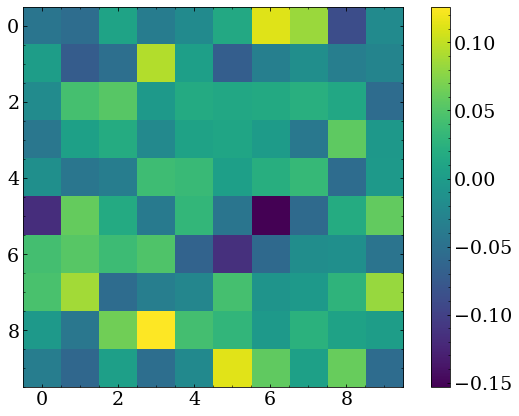

neuron A for conv dimension 1


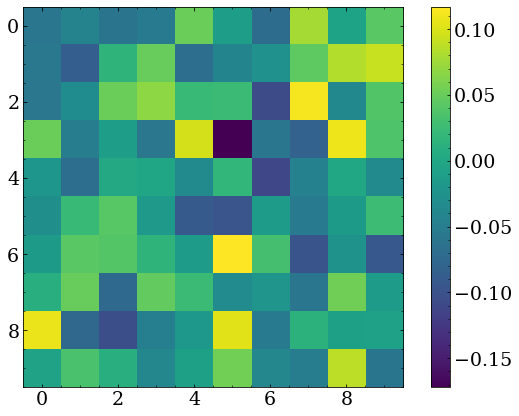

neuron A for conv dimension 2


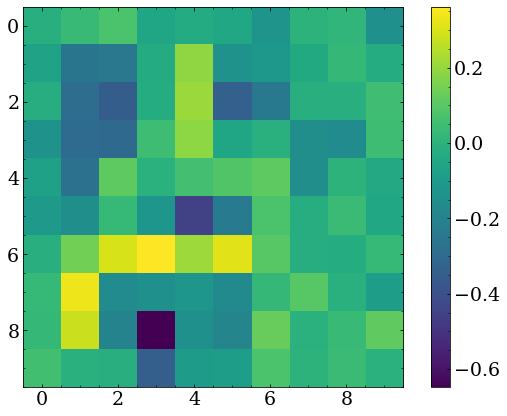

neuron A for conv dimension 3


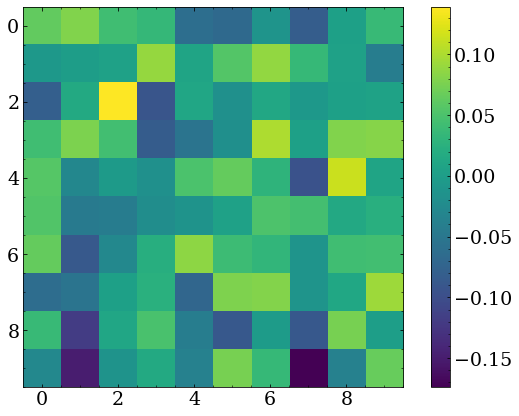

neuron B for conv dimension 0


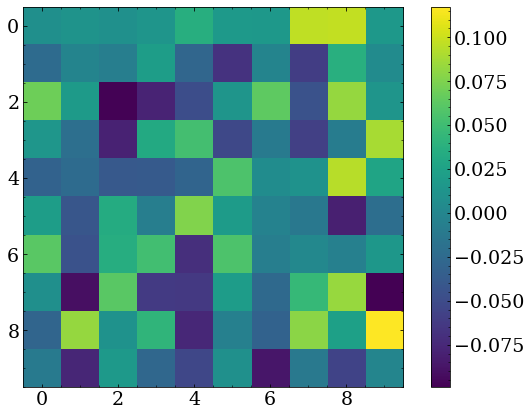

neuron B for conv dimension 1


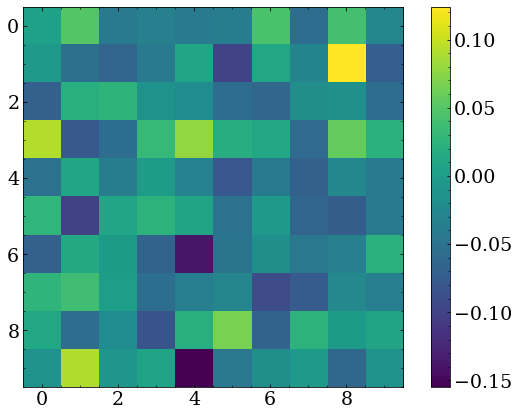

neuron B for conv dimension 2


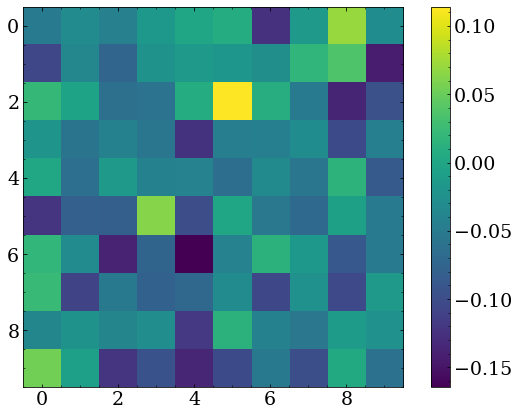

neuron B for conv dimension 3


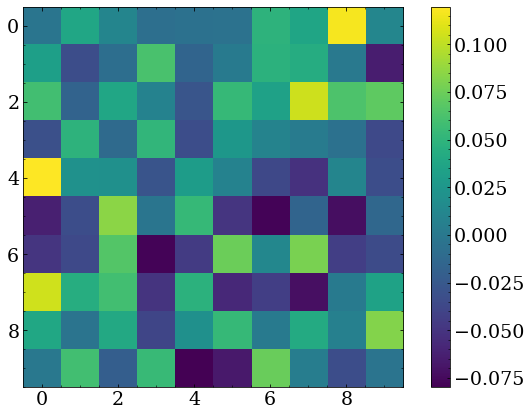

neuron C for conv dimension 0


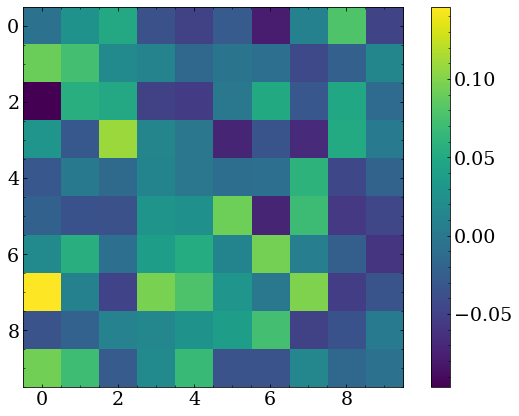

neuron C for conv dimension 1


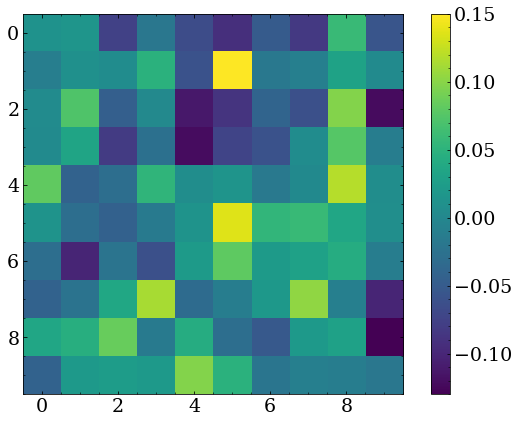

neuron C for conv dimension 2


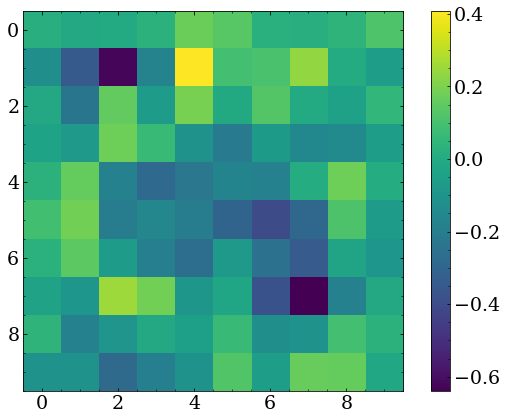

neuron C for conv dimension 3


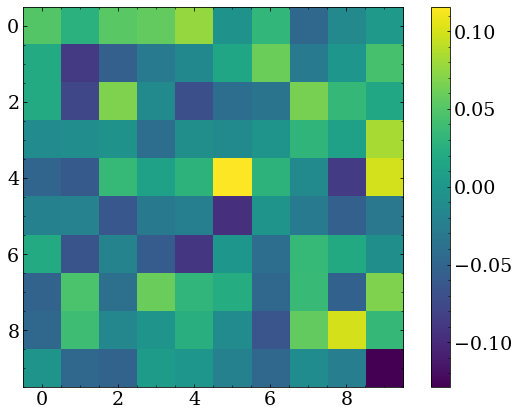

neuron D for conv dimension 0


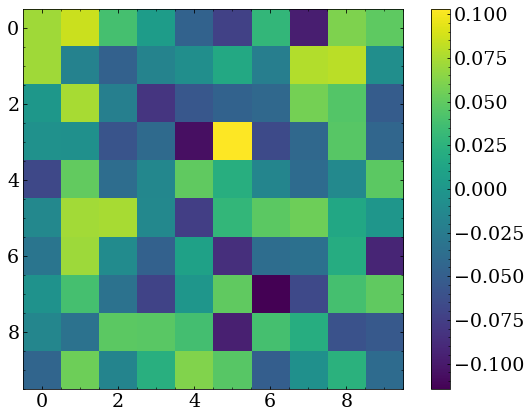

neuron D for conv dimension 1


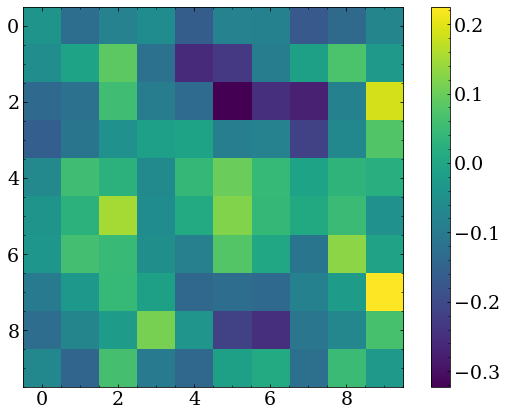

neuron D for conv dimension 2


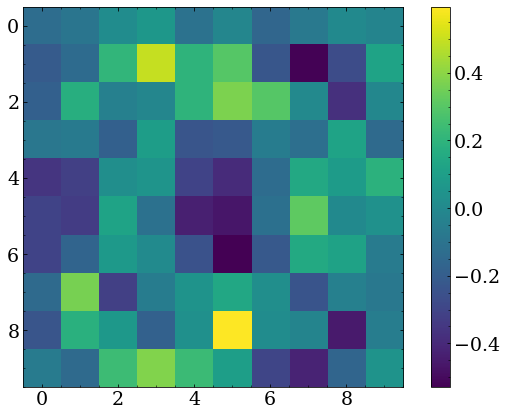

neuron D for conv dimension 3


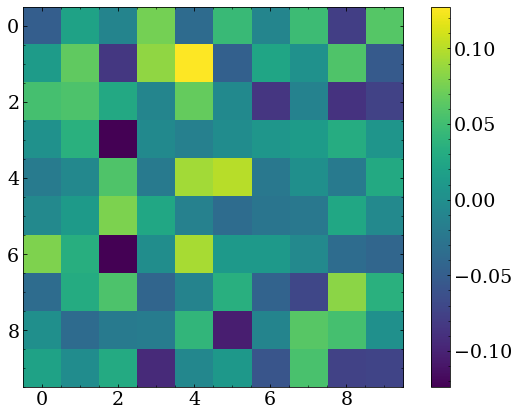

neuron E for conv dimension 0


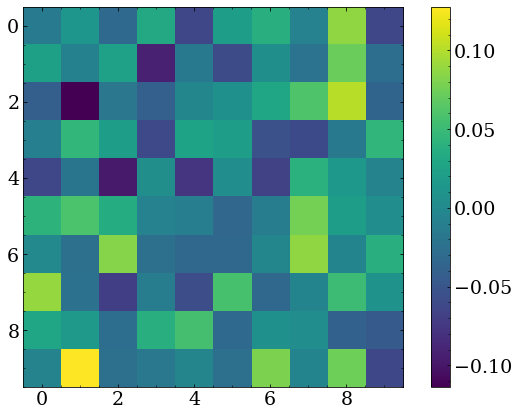

neuron E for conv dimension 1


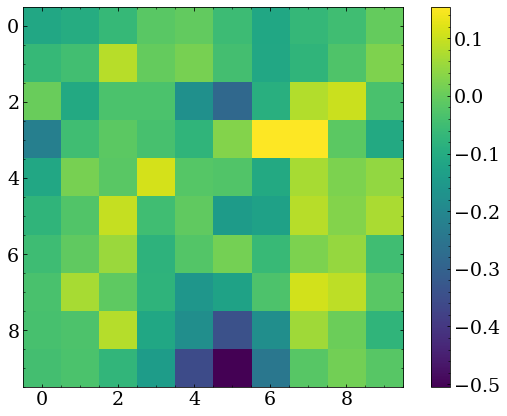

neuron E for conv dimension 2


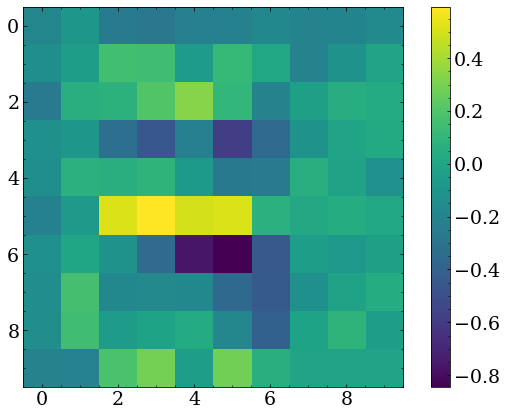

neuron E for conv dimension 3


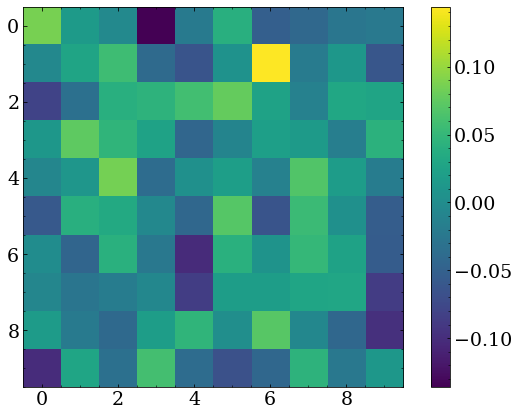

neuron F for conv dimension 0


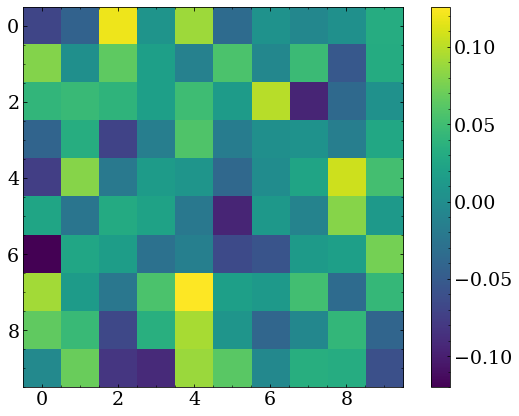

neuron F for conv dimension 1


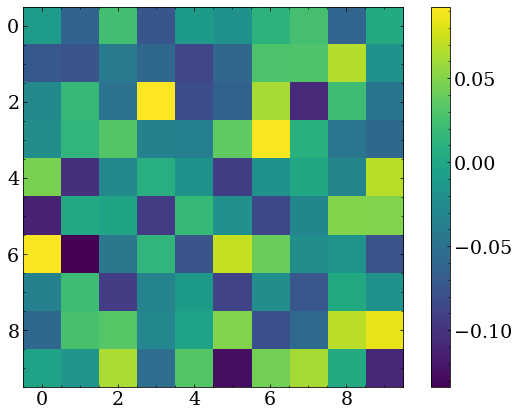

neuron F for conv dimension 2


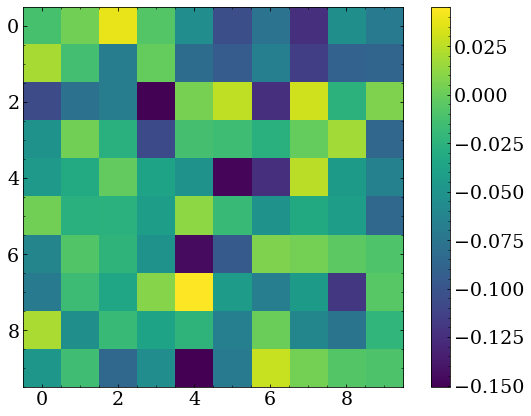

neuron F for conv dimension 3


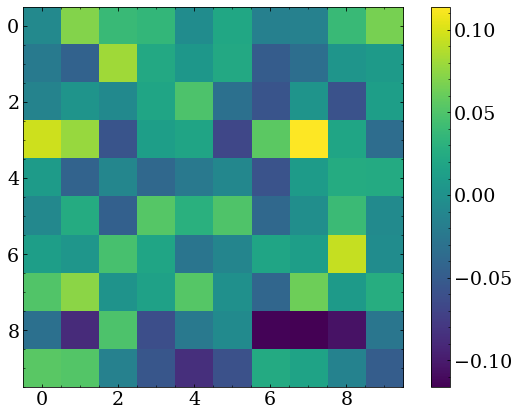

neuron G for conv dimension 0


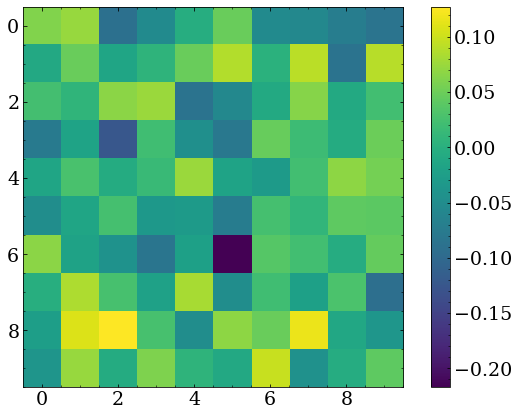

neuron G for conv dimension 1


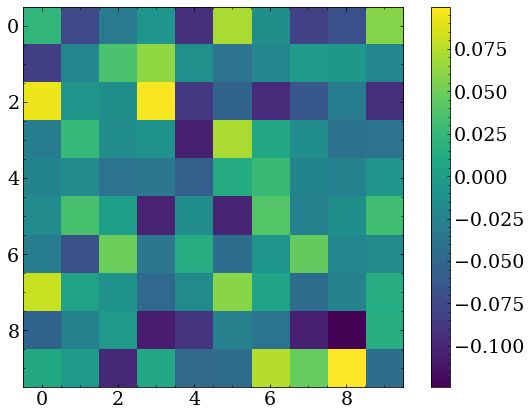

neuron G for conv dimension 2


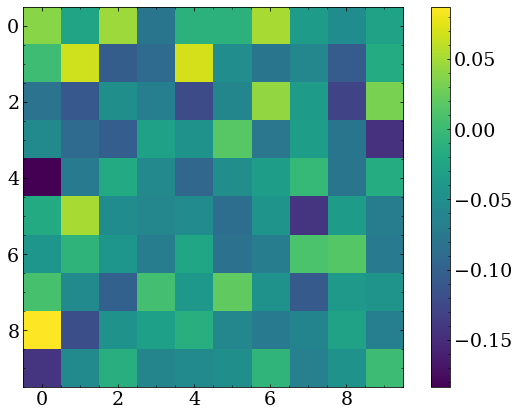

neuron G for conv dimension 3


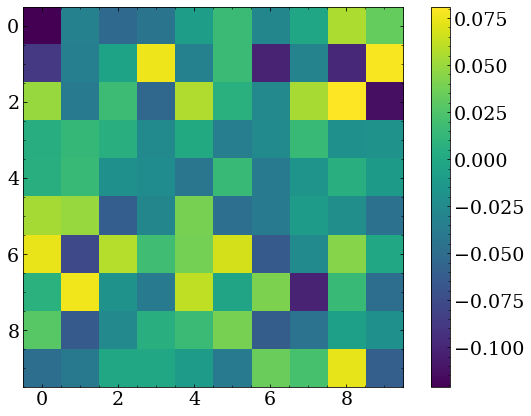

neuron H for conv dimension 0


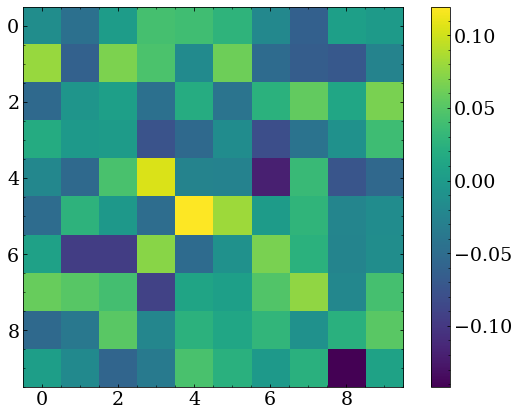

neuron H for conv dimension 1


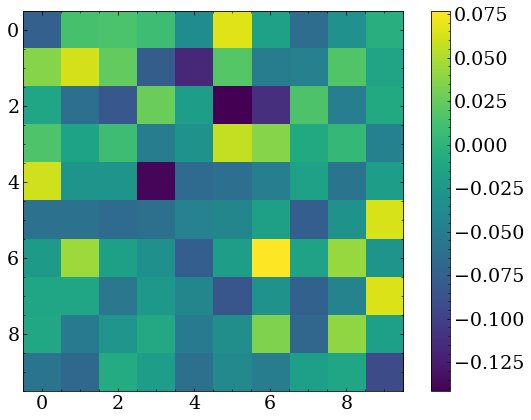

neuron H for conv dimension 2


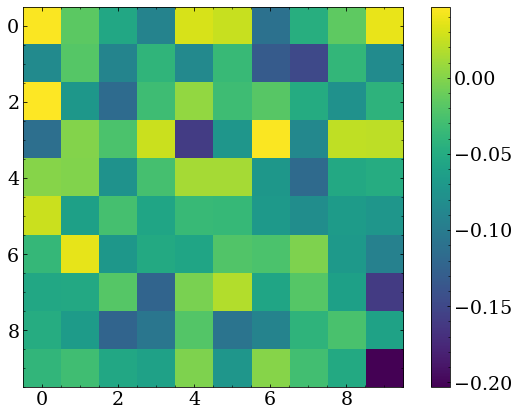

neuron H for conv dimension 3


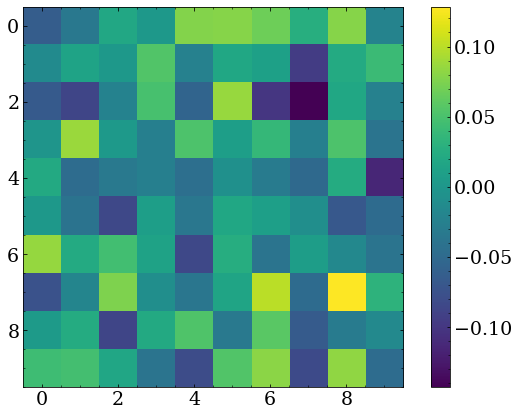

neuron I for conv dimension 0


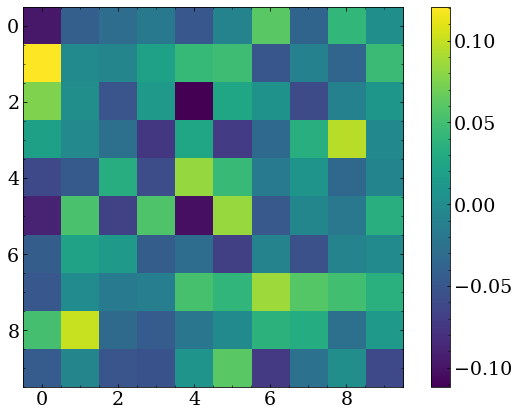

neuron I for conv dimension 1


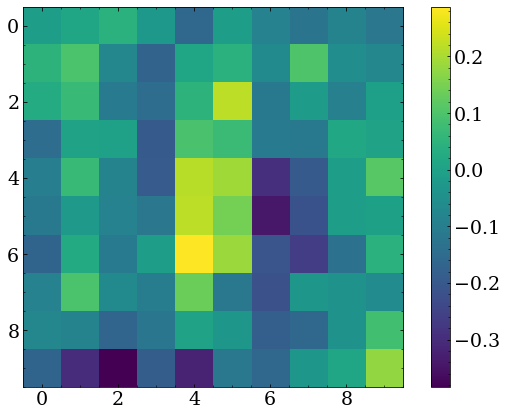

neuron I for conv dimension 2


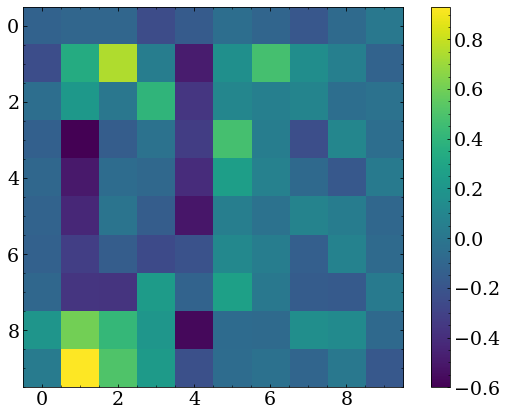

neuron I for conv dimension 3


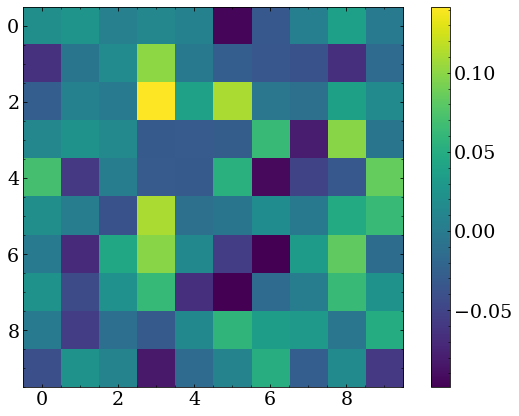

neuron J for conv dimension 0


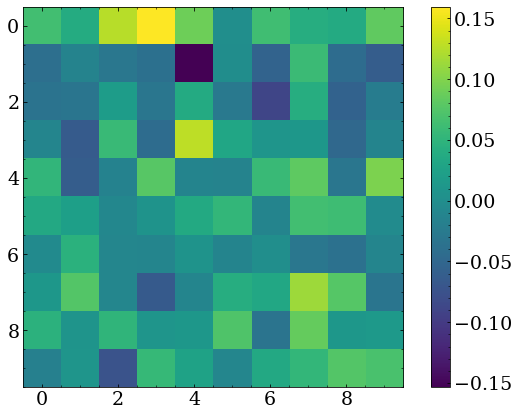

neuron J for conv dimension 1


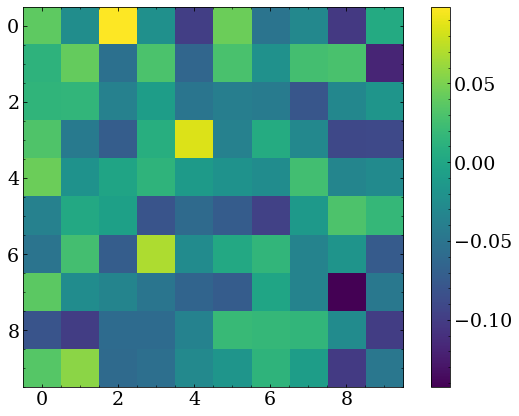

neuron J for conv dimension 2


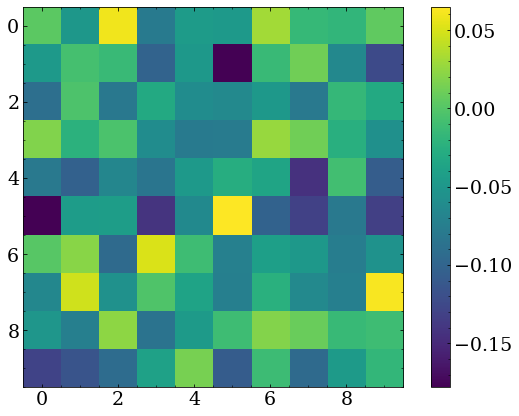

neuron J for conv dimension 3


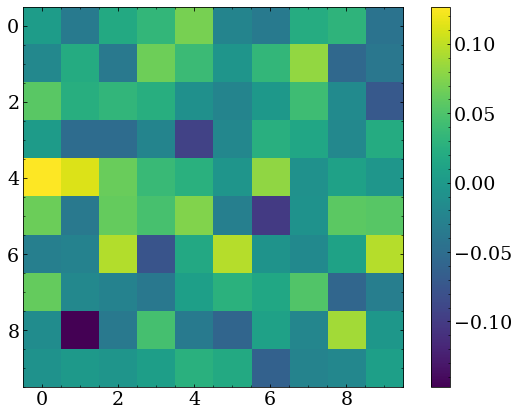

neuron K for conv dimension 0


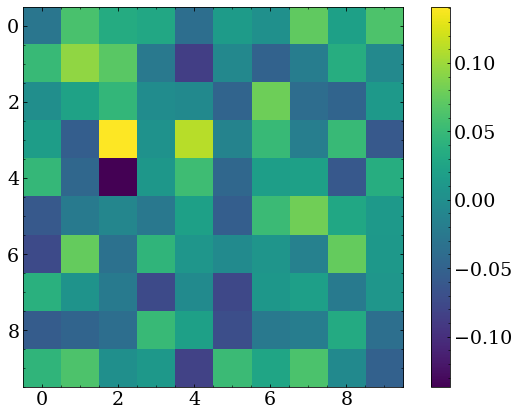

neuron K for conv dimension 1


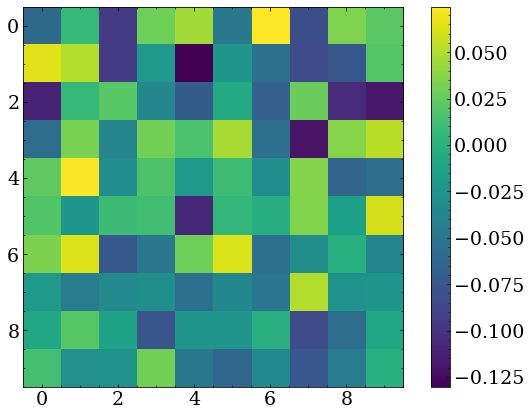

neuron K for conv dimension 2


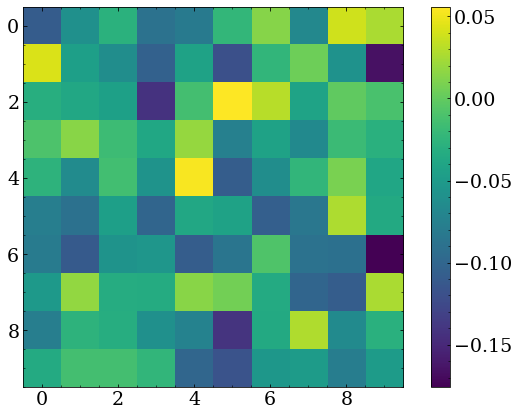

neuron K for conv dimension 3


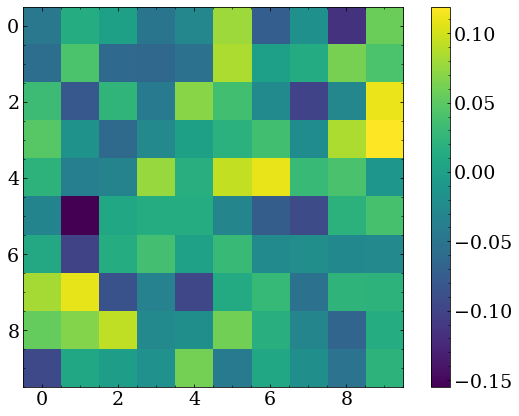

neuron L for conv dimension 0


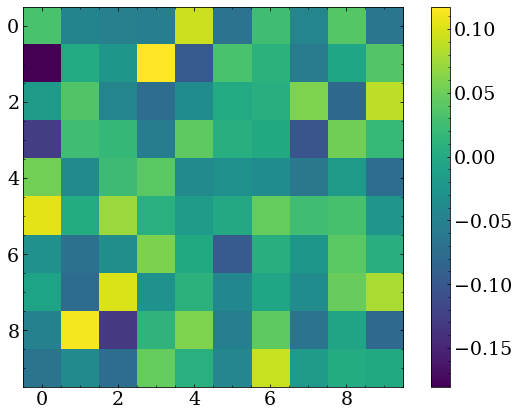

neuron L for conv dimension 1


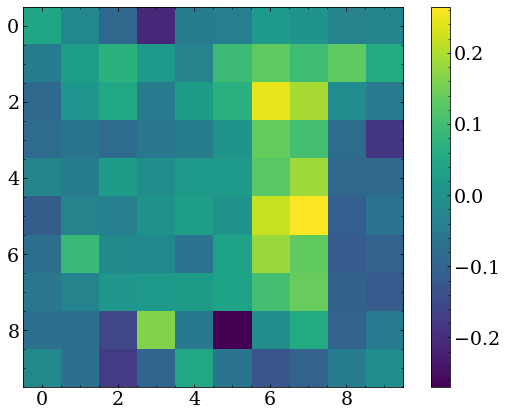

neuron L for conv dimension 2


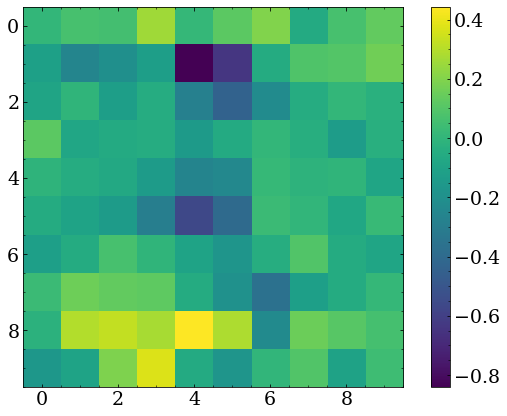

neuron L for conv dimension 3


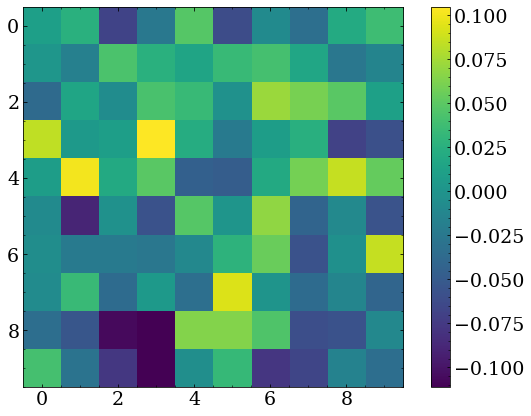

neuron M for conv dimension 0


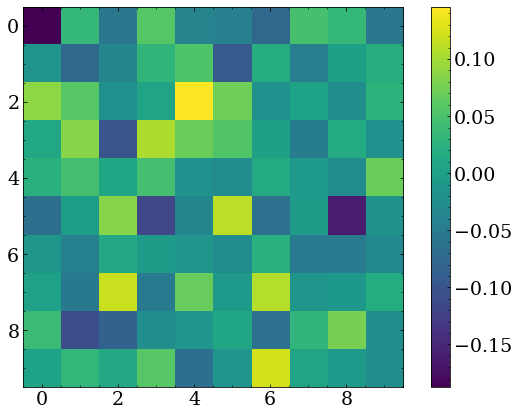

neuron M for conv dimension 1


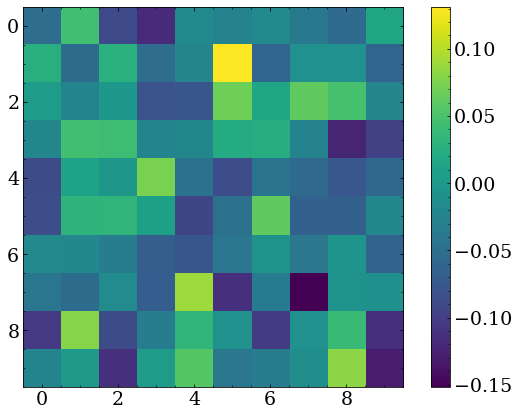

neuron M for conv dimension 2


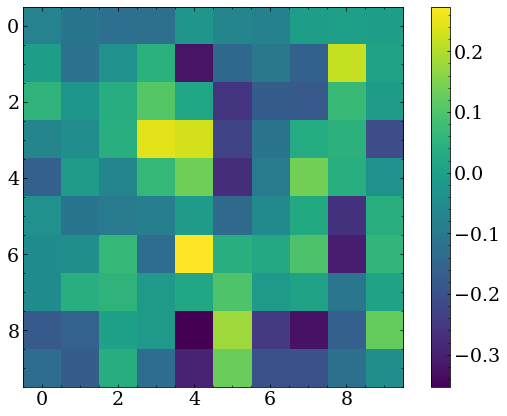

neuron M for conv dimension 3


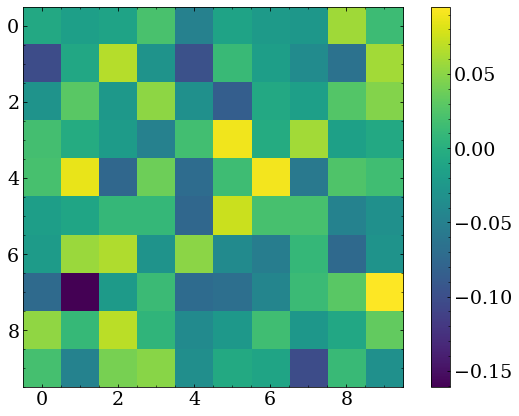

neuron N for conv dimension 0


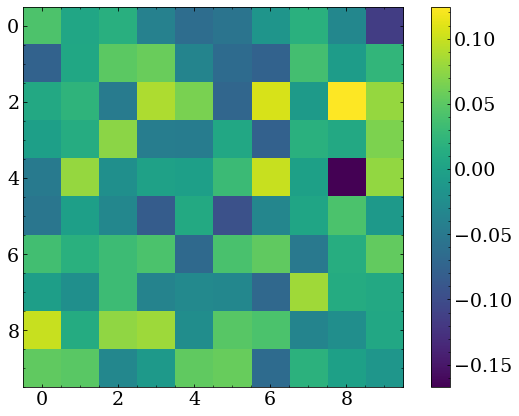

neuron N for conv dimension 1


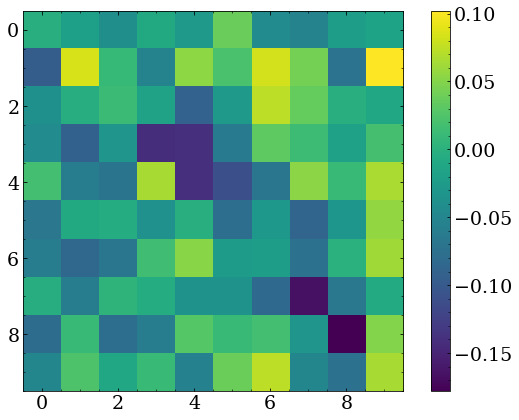

neuron N for conv dimension 2


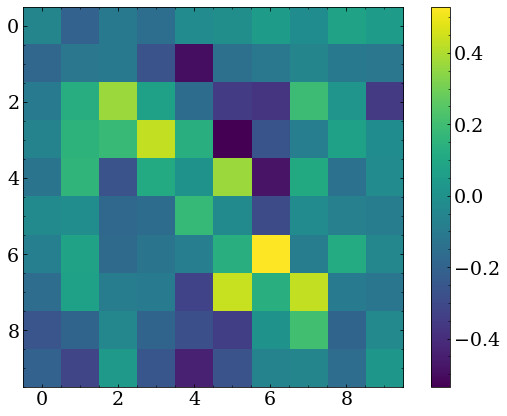

neuron N for conv dimension 3


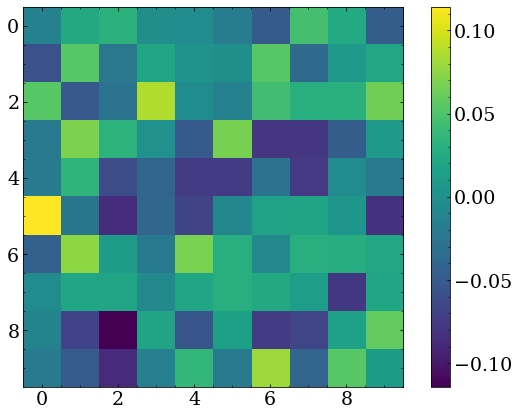

neuron O for conv dimension 0


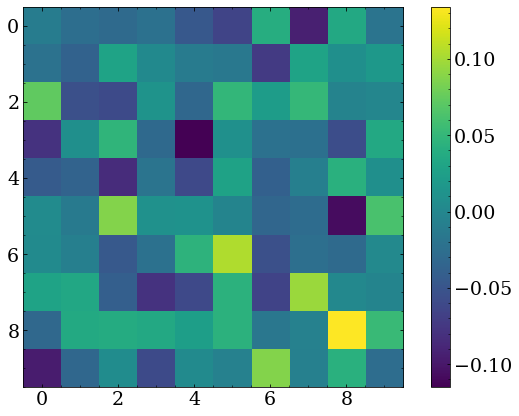

neuron O for conv dimension 1


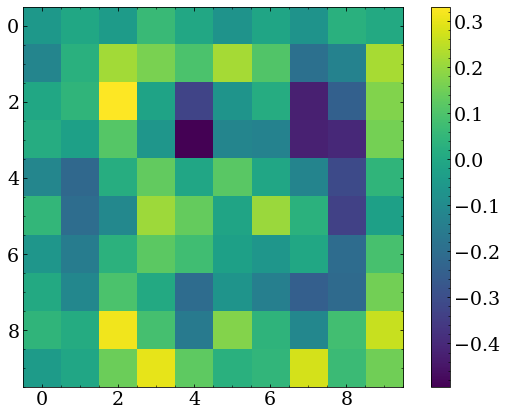

neuron O for conv dimension 2


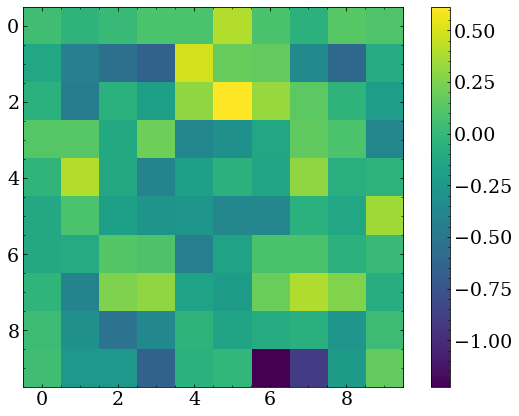

neuron O for conv dimension 3


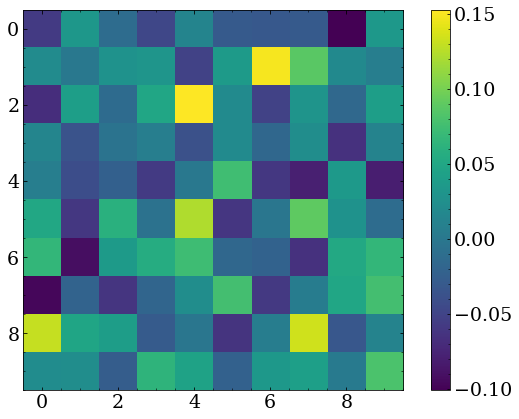

neuron P for conv dimension 0


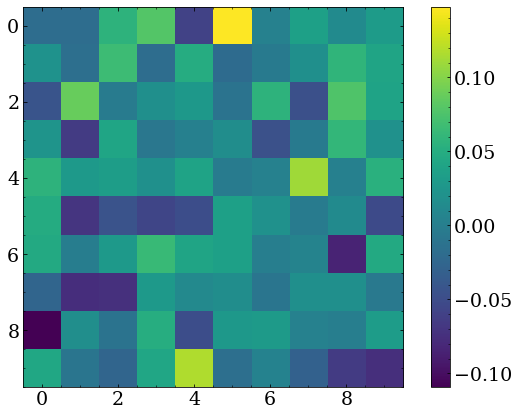

neuron P for conv dimension 1


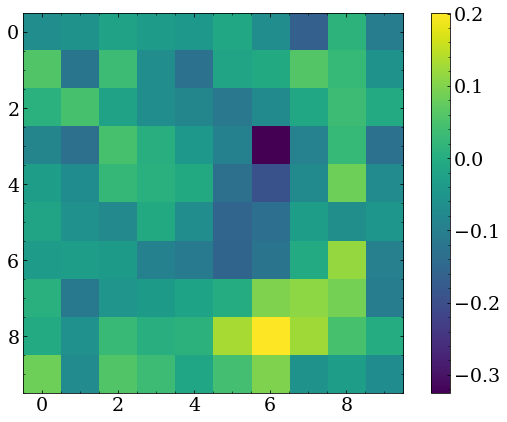

neuron P for conv dimension 2


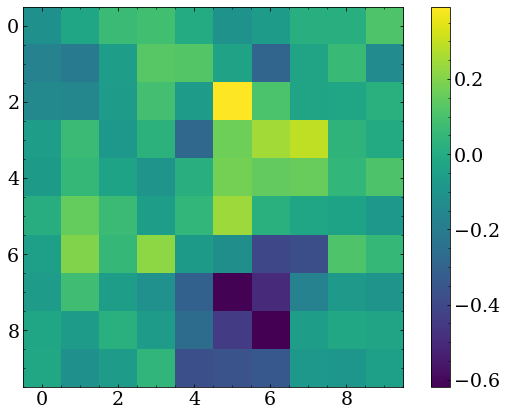

neuron P for conv dimension 3


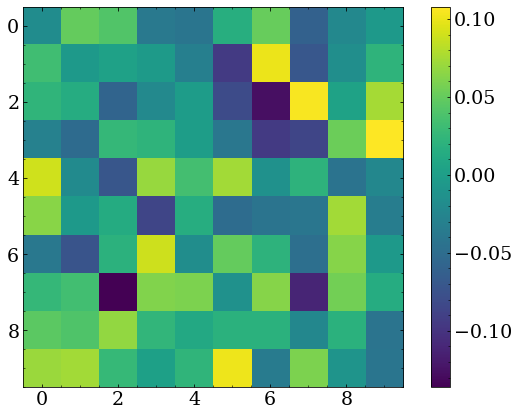

neuron Q for conv dimension 0


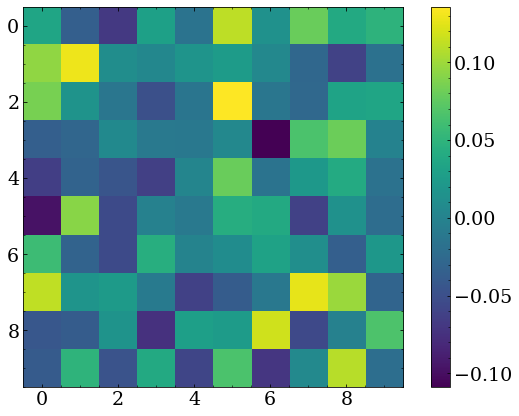

neuron Q for conv dimension 1


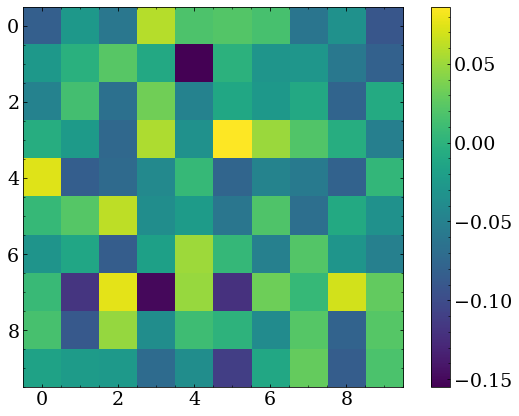

neuron Q for conv dimension 2


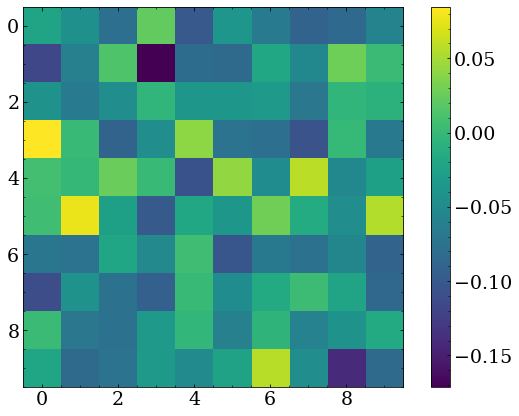

neuron Q for conv dimension 3


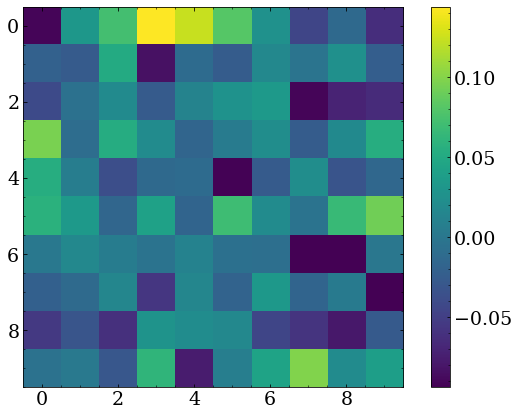

neuron R for conv dimension 0


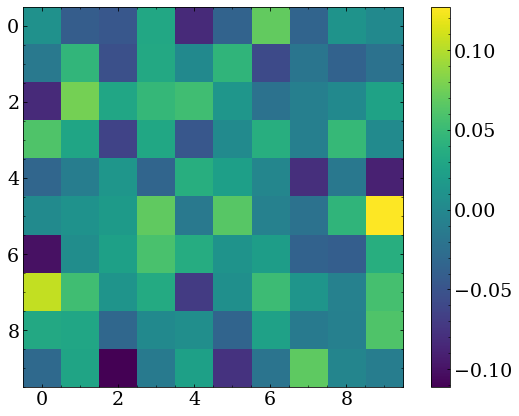

neuron R for conv dimension 1


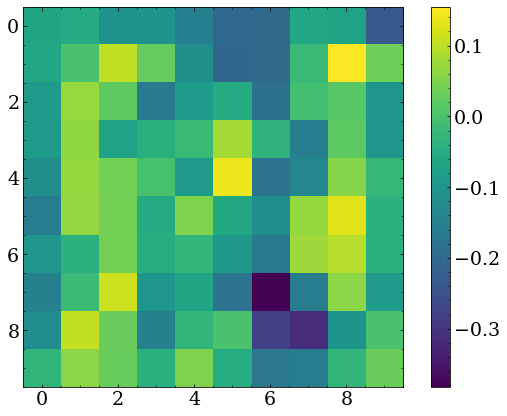

neuron R for conv dimension 2


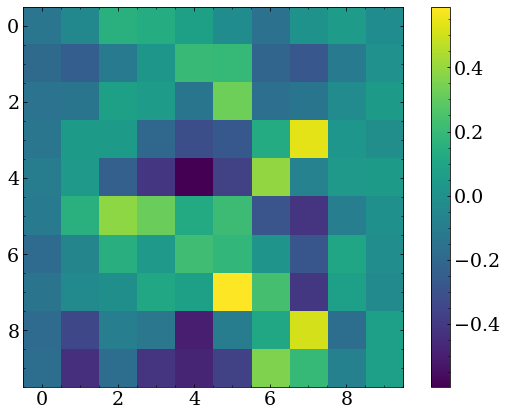

neuron R for conv dimension 3


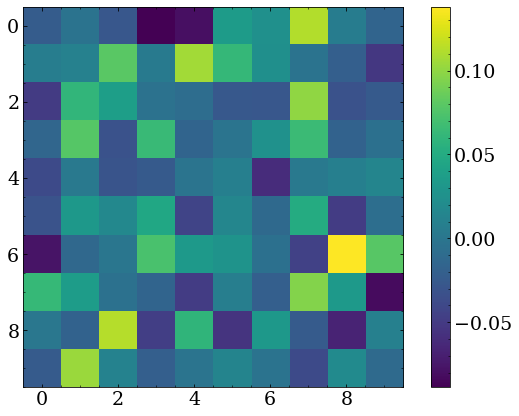

neuron S for conv dimension 0


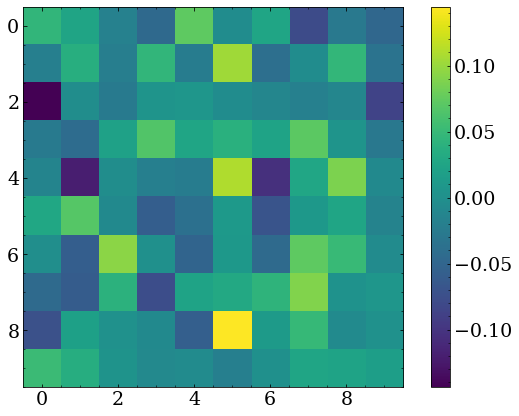

neuron S for conv dimension 1


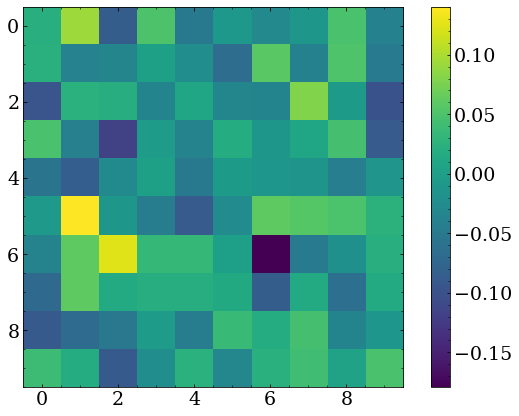

neuron S for conv dimension 2


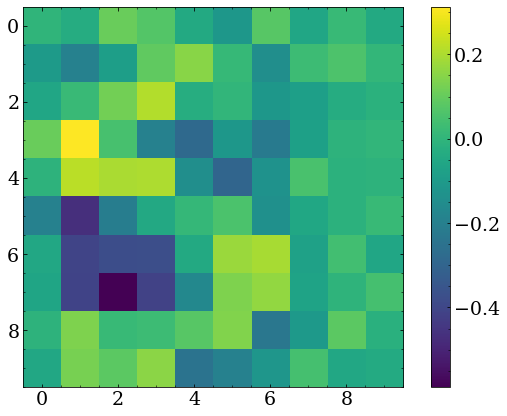

neuron S for conv dimension 3


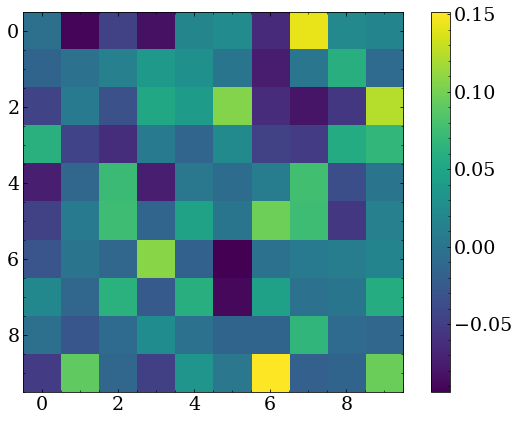

neuron T for conv dimension 0


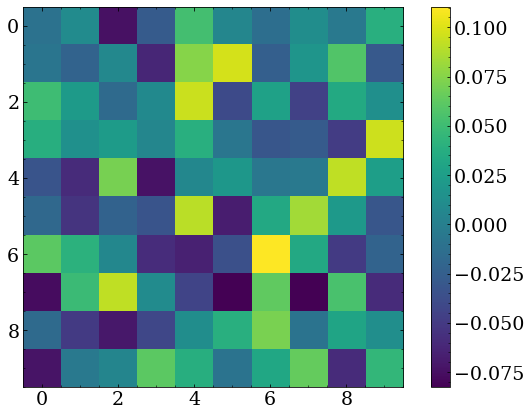

neuron T for conv dimension 1


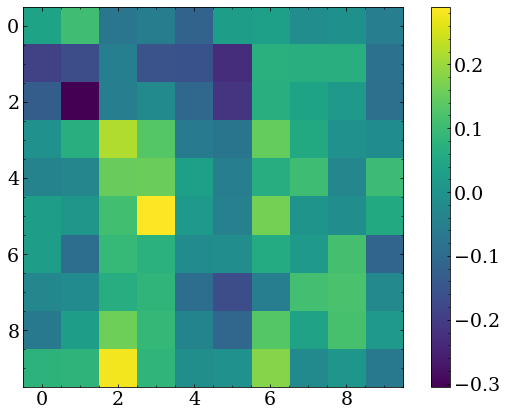

neuron T for conv dimension 2


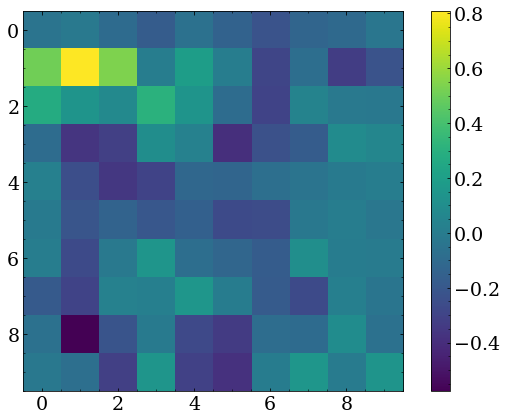

neuron T for conv dimension 3


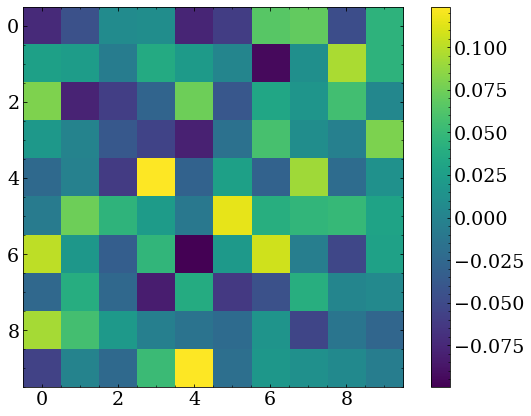

neuron U for conv dimension 0


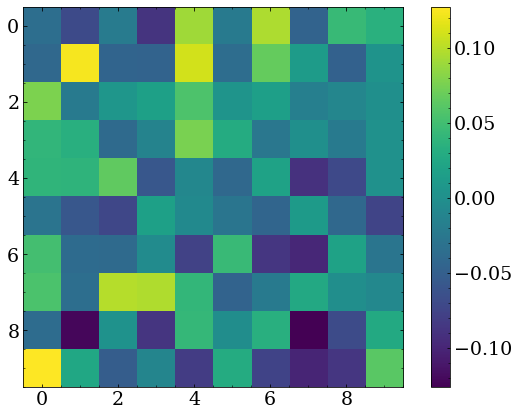

neuron U for conv dimension 1


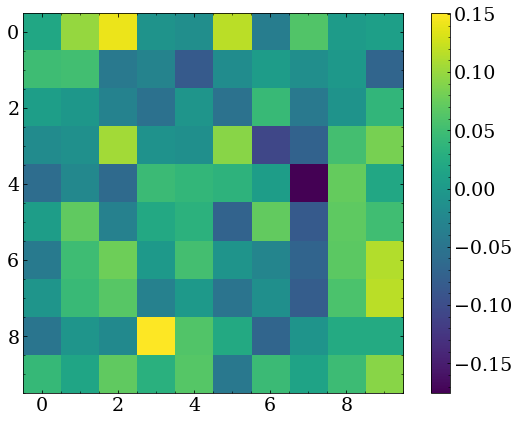

neuron U for conv dimension 2


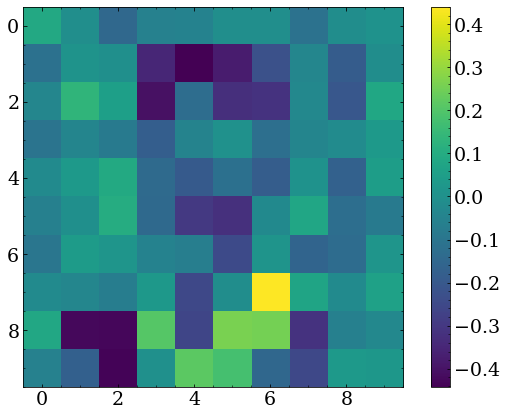

neuron U for conv dimension 3


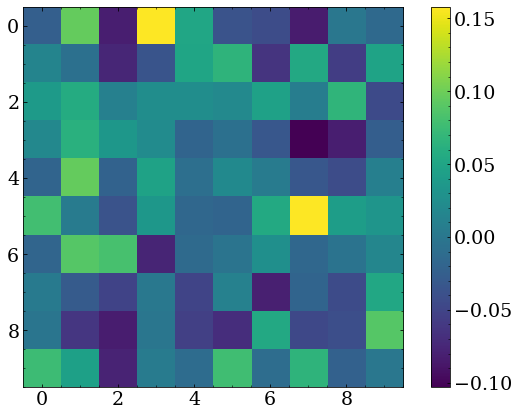

neuron V for conv dimension 0


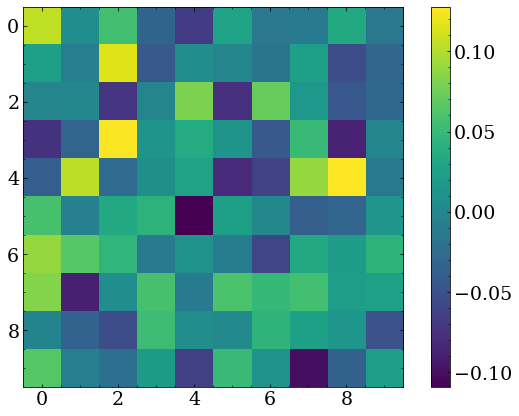

neuron V for conv dimension 1


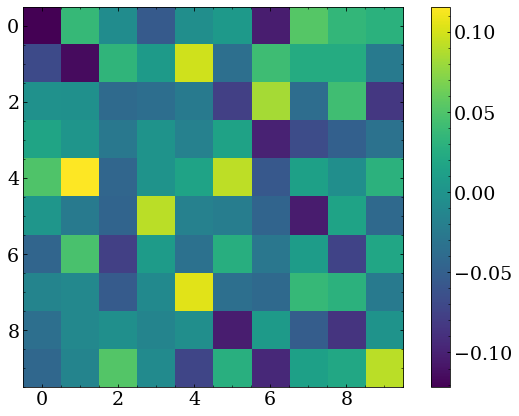

neuron V for conv dimension 2


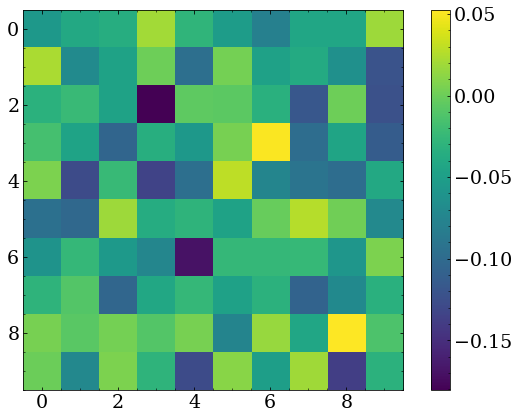

neuron V for conv dimension 3


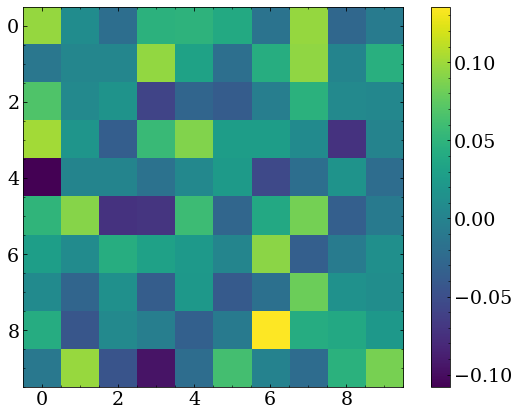

neuron W for conv dimension 0


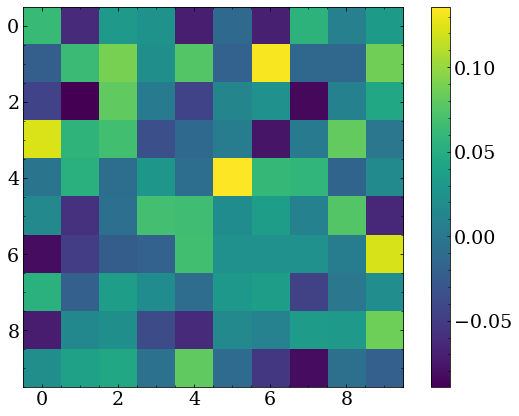

neuron W for conv dimension 1


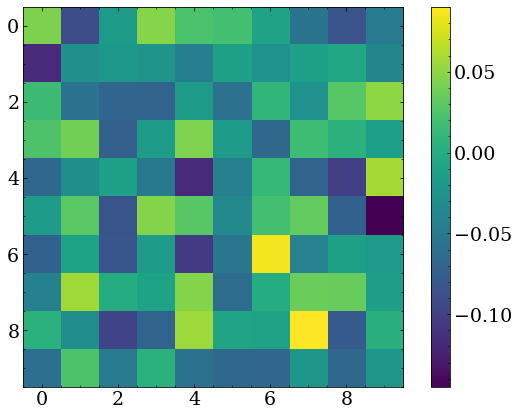

neuron W for conv dimension 2


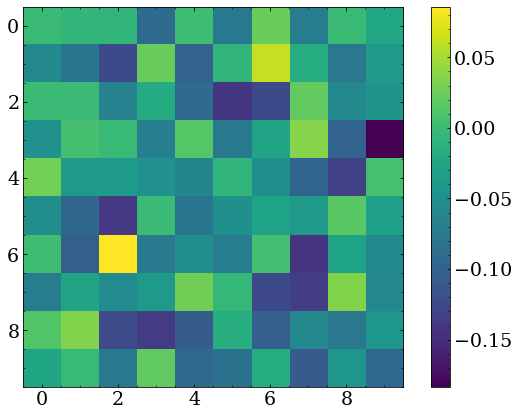

neuron W for conv dimension 3


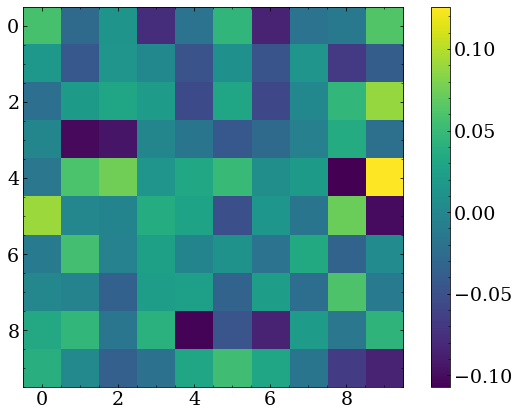

neuron X for conv dimension 0


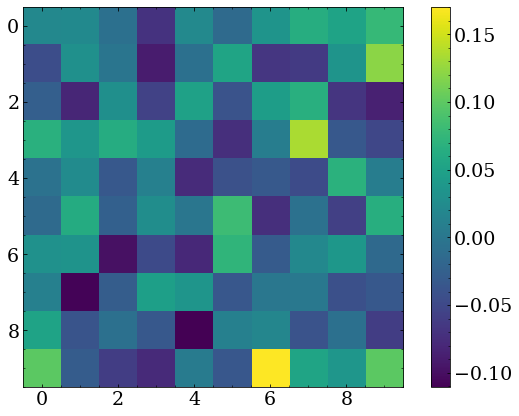

neuron X for conv dimension 1


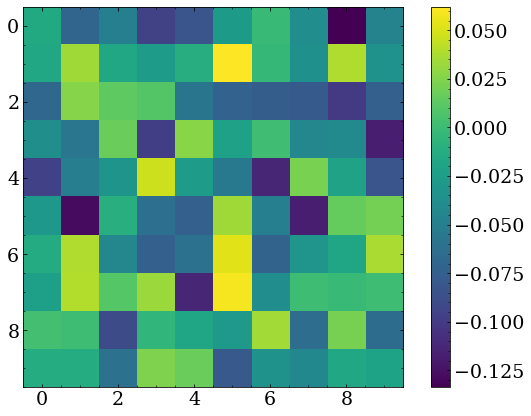

neuron X for conv dimension 2


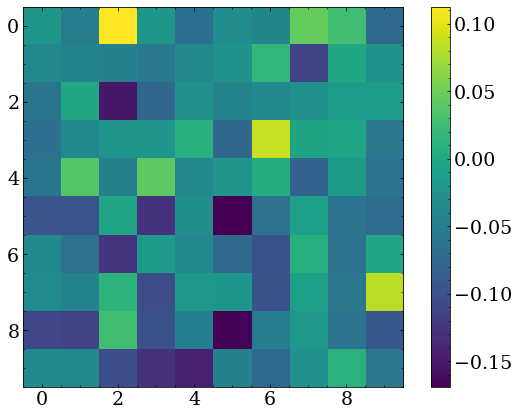

neuron X for conv dimension 3


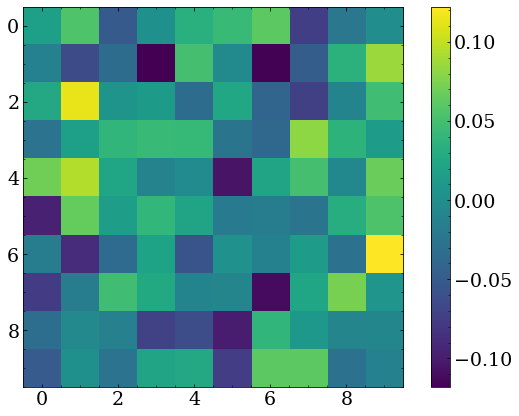

neuron Y for conv dimension 0


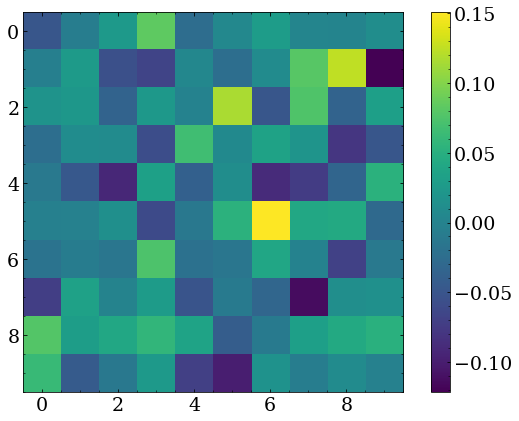

neuron Y for conv dimension 1


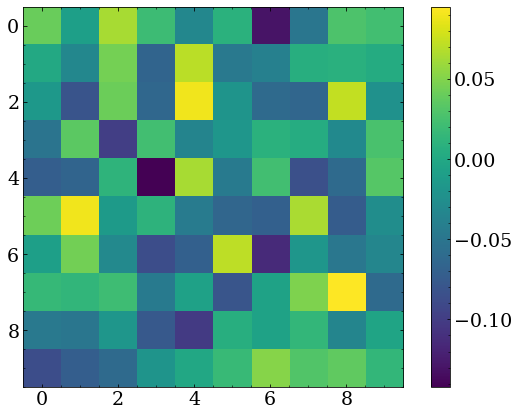

neuron Y for conv dimension 2


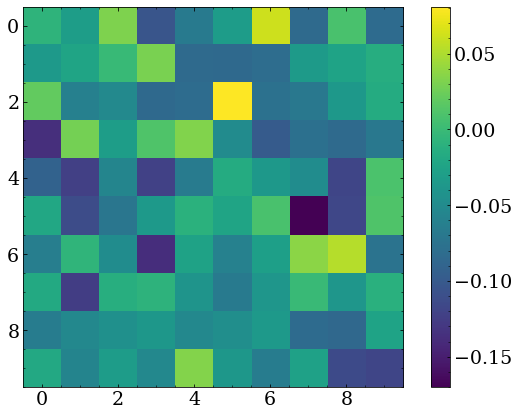

neuron Y for conv dimension 3


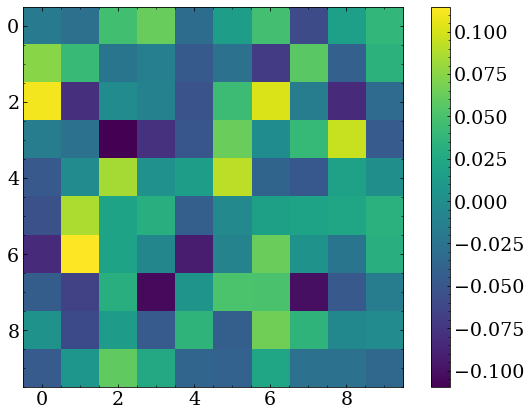

In [29]:
for c,l in zip(range(ord('A'),ord('Z')),s.parts[-3].layer):
    for i in range(4):
        print('neuron',chr(c),'for conv dimension',i)
        plt.imshow(l.weights[1:].reshape((10,10,4))[:,:,i])
        plt.colorbar()
        plt.show()
        plt.close()

conv kernel 0


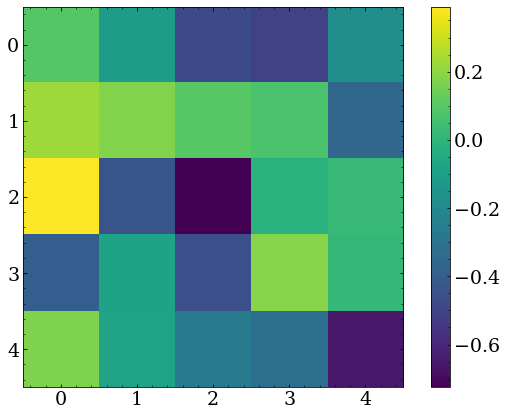

conv kernel 1


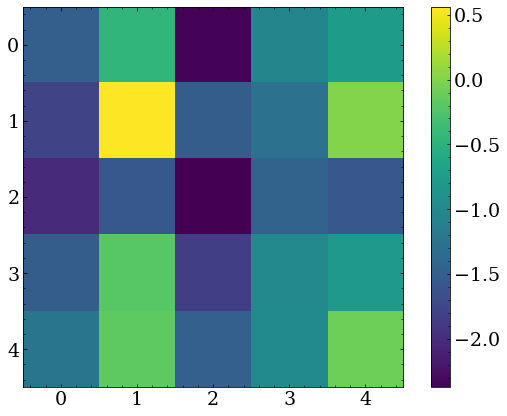

conv kernel 2


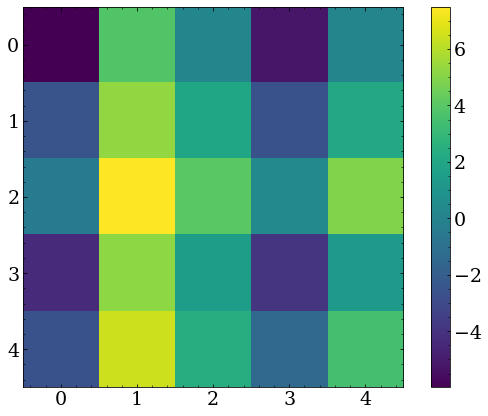

conv kernel 3


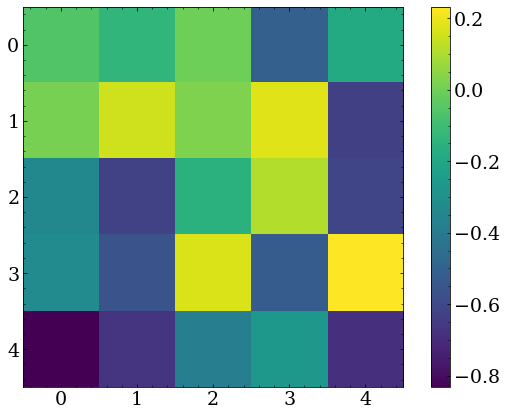

In [31]:
for i,l in enumerate(s.parts[-2].layer):
    print('conv kernel',i)
    plt.imshow(l.weights[1:].reshape((5,5)))
    plt.colorbar()
    plt.show()
    plt.close()